In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import random

In [3]:
# Load dataset
df = pd.read_csv("pca_resampled_data.csv")

# Separate features and target
X = df.drop('Target', axis=1).values
y = df['Target'].values

# Reshape features: (samples, timesteps, features)
X = X.reshape((X.shape[0], 109, 3))

# Encode and one-hot encode target
le = LabelEncoder()
y = le.fit_transform(y)
y_cat = to_categorical(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)


In [5]:
from tensorflow.keras.layers import Bidirectional

# Build BiLSTM model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(109, 3)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))  

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

C:\Users\sihus\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step - accuracy: 0.3930 - loss: 1.3280 - val_accuracy: 0.5526 - val_loss: 1.1436
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.6262 - loss: 0.9836 - val_accuracy: 0.7632 - val_loss: 0.6251
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.7633 - loss: 0.5656 - val_accuracy: 0.8289 - val_loss: 0.4101
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.8276 - loss: 0.4154 - val_accuracy: 0.8728 - val_loss: 0.3136
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.8747 - loss: 0.3260 - val_accuracy: 0.8728 - val_loss: 0.2797
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9028 - loss: 0.2534 - val_accuracy: 0.8816 - val_loss: 0.3063
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9236 - loss: 0.2252 - val_accuracy: 0.9079 - val_loss: 0.2519
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9134 - loss: 0.2163 - val_accuracy: 0

In [7]:
# Save the model
model.save("ecg_bilstm_model.keras")
print("Model saved as ecg_bilstm_model.keras")

Model saved as ecg_bilstm_model.keras


In [11]:
from tensorflow.keras.models import load_model 
# Load the model 
loaded_model = load_model("ecg_bilstm_model.keras")
print("Model loaded successfully.")

# Evaluate loaded model
loss_loaded, accuracy_loaded = loaded_model.evaluate(X_test, y_test)
print(f"Loaded Model Accuracy: {accuracy_loaded:.4f}")


Model loaded successfully.
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9541 - loss: 0.1612
Loaded Model Accuracy: 0.9474


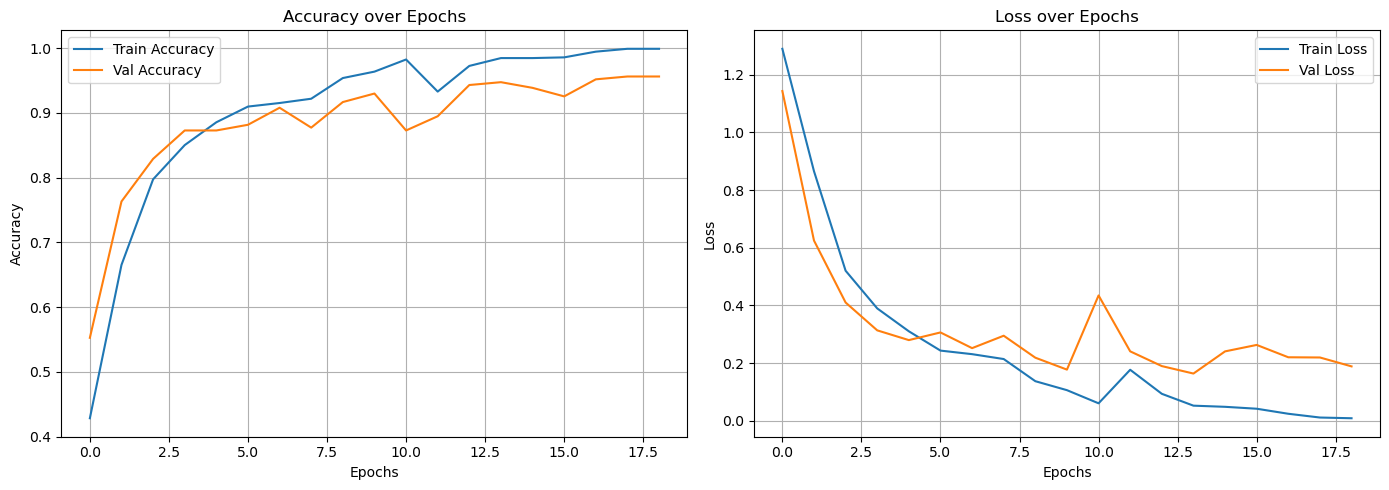

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step


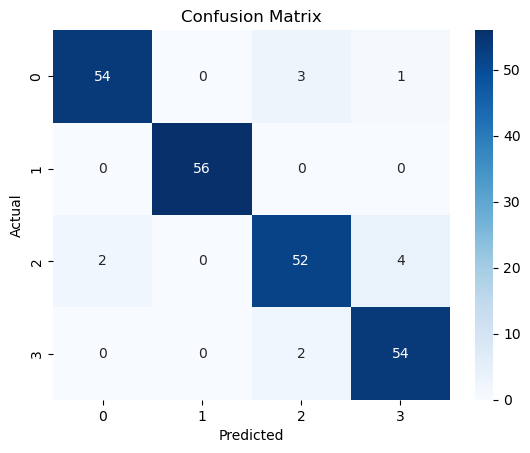


Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.93      0.95        58
           1       1.00      1.00      1.00        56
           2       0.91      0.90      0.90        58
           3       0.92      0.96      0.94        56

    accuracy                           0.95       228
   macro avg       0.95      0.95      0.95       228
weighted avg       0.95      0.95      0.95       228



In [13]:
# Plot Accuracy & Loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix & Classification Report
y_pred = loaded_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=[str(c) for c in le.classes_]))

In [18]:
# Random Test Sample
random_index = random.randint(0, X_test.shape[0] - 1)
sample = X_test[random_index].reshape(1, 109, 3)
predicted_class = np.argmax(loaded_model.predict(sample), axis=1)[0]
actual_class = np.argmax(y_test[random_index])
print(f"\nRandom Test Sample {random_index}")
print(f"Actual Class   : {actual_class}")
print(f"Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Random Test Sample 202
Actual Class   : 2
Predicted Class: 2


In [22]:
# Random Test Sample
random_index = random.randint(0, X_test.shape[0] - 1)
sample = X_test[random_index].reshape(1, 109, 3)
predicted_class = np.argmax(loaded_model.predict(sample), axis=1)[0]
actual_class = np.argmax(y_test[random_index])
print(f"\nRandom Test Sample {random_index}")
print(f"Actual Class   : {actual_class}")
print(f"Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

Random Test Sample 18
Actual Class   : 1
Predicted Class: 1


In [3]:
from tensorflow.keras.models import load_model 
# Load the model 
loaded_model = load_model("ecg_bilstm_model.keras")
print("Model loaded successfully.")
loaded_model.summary()

Model loaded successfully.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 109, 256)            │         135,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 109, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 911,342 (3.48 MB)

 Trainable params: 303,780 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 607,562 (2.32 MB)